In [3]:
!pip install onnxmltools
!pip install skl2onnx
!pip install onnxruntime

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import onnxmltools, onnxruntime as ort
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, RobustScaler
import json, hashlib, datetime
import matplotlib.pyplot as plt
import seaborn as sns

models_dir = Path("/home/ashwinvel2000/TAQA/models_3")
healthy_df = pd.read_parquet("/home/ashwinvel2000/TAQA/training_data/wide36_tools_flat.parquet")
print("rows for ML:", len(healthy_df))

rows for ML: 1288266


=== CHOKE FEATURES ANALYSIS ===

Choke-Position:


  Range: -1.892 to 102.865
  Mean±Std: 67.548 ± 47.117
  Quantiles: {0.01: -1.189178, 0.05: -0.8648529, 0.95: 101.0811, 0.99: 101.1892}

ToolStateNum:
  Range: 0.000 to 7680.000
  Mean±Std: 2.900 ± 7.115
  Quantiles: {0.01: 0.0, 0.05: 0.0, 0.95: 6.0, 0.99: 10.0}
  Value counts (top 10):
ToolStateNum
2.0     727706
6.0     255056
0.0     118002
1.0      84726
5.0      41646
3.0      14498
10.0     14113
7.0       9361
9.0       8686
8.0       5028
Name: count, dtype: int64

Downstream-Temperature:
  Range: 7.411 to 108.216
  Mean±Std: 23.531 ± 22.892
  Quantiles: {0.01: 12.80093, 0.05: 13.41162, 0.95: 96.8151175, 0.99: 108.0884}


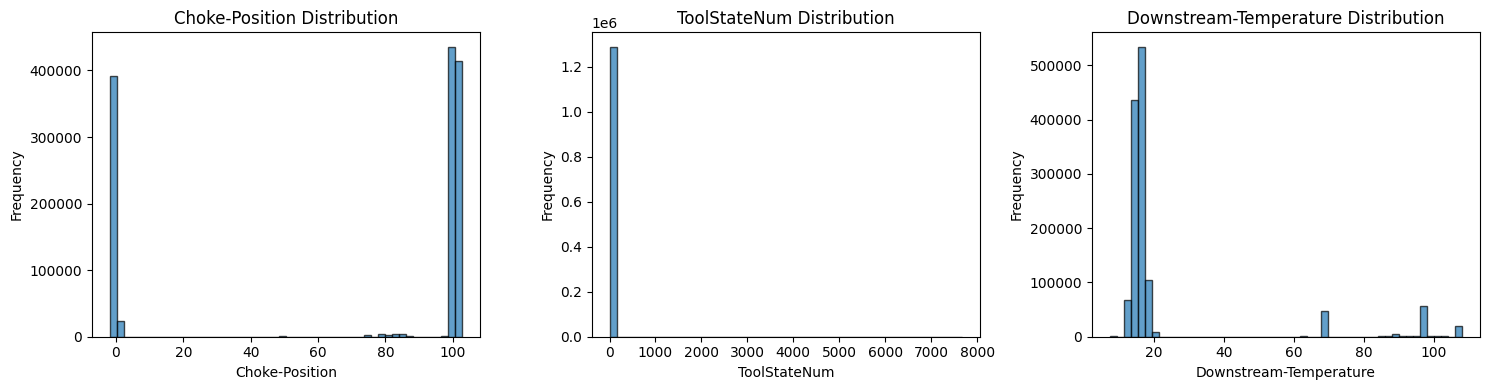

In [5]:
# Feature definitions
IF_CHOKE_FEATS = ["Choke-Position", "ToolStateNum", "Downstream-Temperature"]

# Analyze the distribution of choke features to understand the data better
print("=== CHOKE FEATURES ANALYSIS ===")
for col in IF_CHOKE_FEATS:
    print(f"\n{col}:")
    print(f"  Range: {healthy_df[col].min():.3f} to {healthy_df[col].max():.3f}")
    print(f"  Mean±Std: {healthy_df[col].mean():.3f} ± {healthy_df[col].std():.3f}")
    print(f"  Quantiles: {healthy_df[col].quantile([0.01, 0.05, 0.95, 0.99]).to_dict()}")
    if col == "ToolStateNum":
        print(f"  Value counts (top 10):\n{healthy_df[col].value_counts().head(10)}")

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(IF_CHOKE_FEATS):
    axes[i].hist(healthy_df[col], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [6]:
def export_improved_if(df_sub, cols, onnx_path, cont=0.01, scale_method='robust', 
                      n_estimators=300, max_samples=0.8, max_features=1.0):
    """
    Enhanced Isolation Forest export with preprocessing and tuning.
    
    Args:
        scale_method: 'robust', 'standard', or 'none'
        n_estimators: More trees for better performance (default 300 vs 200)
        max_samples: Subsample ratio for each tree (0.8 vs default 'auto')
        max_features: Feature subsample ratio (1.0 = use all features)
    """
    print(f"Training improved IF for {onnx_path.name} with {scale_method} scaling...")
    
    # Get raw features
    X_raw = df_sub[cols].astype(np.float32).values
    print(f"  Raw data shape: {X_raw.shape}")
    
    # Apply scaling if requested
    if scale_method == 'robust':
        scaler = RobustScaler()
        X = scaler.fit_transform(X_raw).astype(np.float32)
        print(f"  Applied RobustScaler (median centering, IQR scaling)")
    elif scale_method == 'standard':
        scaler = StandardScaler()
        X = scaler.fit_transform(X_raw).astype(np.float32)
        print(f"  Applied StandardScaler (z-score normalization)")
    else:
        X = X_raw
        scaler = None
        print(f"  No scaling applied")
    
    # Train model with improved hyperparameters
    model = IsolationForest(
        n_estimators=n_estimators,      # More trees
        contamination=cont,
        max_samples=max_samples,        # Subsample for diversity
        max_features=max_features,      # Feature bagging
        random_state=42
    ).fit(X)
    
    print(f"  Model trained with contamination={cont}")
    
    # Convert to ONNX (using same simple approach as baseline)
    print(f"  Converting to ONNX...")
    initial_type = [('input', FloatTensorType([None, X.shape[1]]))]
    onnx_model = convert_sklearn(model, initial_types=initial_type,
                               target_opset={'': 12, 'ai.onnx.ml': 3})
    
    # Add only basic metadata (same as baseline)
    meta = onnx_model.metadata_props.add()
    meta.key, meta.value = "feature_names", ','.join(cols)
    
    # REMOVED: Problematic scaling metadata that was causing hangs
    # We'll store scaler info separately if needed
    
    # Save
    print(f"  Saving ONNX file...")
    onnx_path.parent.mkdir(parents=True, exist_ok=True)
    onnx_path.write_bytes(onnx_model.SerializeToString())
    print(f"  ✓ Saved {onnx_path.name}")
    
    # Save scaler separately if needed for later use
    if scaler is not None:
        scaler_path = onnx_path.with_suffix('.scaler.json')
        scaler_info = {
            "method": scale_method,
            "center": scaler.center_.tolist() if hasattr(scaler, 'center_') else scaler.median_.tolist(),
            "scale": scaler.scale_.tolist()
        }
        scaler_path.write_text(json.dumps(scaler_info, indent=2))
        print(f"  ✓ Saved scaler info to {scaler_path.name}")
    
    return model, scaler

In [7]:
# Test different contamination rates to find optimal sensitivity
print("=== CONTAMINATION RATE ANALYSIS ===")
contamination_rates = [0.005, 0.01, 0.02, 0.03, 0.05]

X_choke = healthy_df[IF_CHOKE_FEATS].astype(np.float32).values

results = []
for cont in contamination_rates:
    model = IsolationForest(n_estimators=100, contamination=cont, random_state=42).fit(X_choke)
    labels = model.predict(X_choke)
    anomaly_rate = (labels == -1).mean() * 100
    results.append({'contamination': cont, 'anomaly_rate_pct': anomaly_rate})
    print(f"Contamination={cont:5.3f} → Anomaly rate: {anomaly_rate:5.2f}%")

results_df = pd.DataFrame(results)

# Visualize
plt.figure(figsize=(8, 5))
plt.plot(results_df['contamination'], results_df['anomaly_rate_pct'], 'o-', linewidth=2, markersize=8)
plt.xlabel('Contamination Parameter')
plt.ylabel('Actual Anomaly Rate (%)')
plt.title('Contamination vs Actual Anomaly Detection Rate')
plt.grid(True, alpha=0.3)
plt.show()

# Choose optimal contamination (aim for ~2-3% anomaly rate for better recall)
optimal_cont = 0.02
print(f"\nChosen contamination rate: {optimal_cont} (targets ~2% anomaly rate)")

=== CONTAMINATION RATE ANALYSIS ===


KeyboardInterrupt: 

In [ ]:
# Train the improved choke position model
print("=== TRAINING IMPROVED CHOKE POSITION MODEL ===")

# Train baseline model using EXACT same code as TAQA_model2.ipynb (no wrapper function)
print("\n1. Baseline model (EXACT copy from TAQA_model2.ipynb):")
print("Training baseline with original code...")
X_baseline = healthy_df[IF_CHOKE_FEATS].astype(np.float32).values
model_baseline = IsolationForest(n_estimators=200, contamination=0.01, random_state=42).fit(X_baseline)
print("✓ Model trained")

# Original ONNX conversion (no extra metadata)
onnx_baseline = convert_sklearn(model_baseline, initial_types=[('input', FloatTensorType([None, X_baseline.shape[1]]))],
                              target_opset={'':12, 'ai.onnx.ml':3})
meta_baseline = onnx_baseline.metadata_props.add()
meta_baseline.key, meta_baseline.value = "feature_names", ','.join(IF_CHOKE_FEATS)
(models_dir/"choke_position_baseline.onnx").parent.mkdir(parents=True, exist_ok=True)
(models_dir/"choke_position_baseline.onnx").write_bytes(onnx_baseline.SerializeToString())
print("✓ choke_position_baseline.onnx")

# Train improved models with wrapper function
print("\n2. Improved model - RobustScaler + higher contamination:")
model_improved, scaler_improved = export_improved_if(
    healthy_df, IF_CHOKE_FEATS, 
    models_dir / "choke_position.onnx",  # Override the original
    cont=optimal_cont, scale_method='robust', 
    n_estimators=300, max_samples=0.8
)

print("\n3. Alternative - StandardScaler version:")
model_standard, scaler_standard = export_improved_if(
    healthy_df, IF_CHOKE_FEATS, 
    models_dir / "choke_position_standard.onnx", 
    cont=optimal_cont, scale_method='standard', 
    n_estimators=300, max_samples=0.8
)

=== TRAINING IMPROVED CHOKE POSITION MODEL ===

1. Baseline model (EXACT copy from TAQA_model2.ipynb):
Training baseline with original code...


NameError: name 'healthy_df' is not defined

In [ ]:
# Compare model performance on training data
print("=== MODEL COMPARISON ON TRAINING DATA ===")

X_test = healthy_df[IF_CHOKE_FEATS].astype(np.float32).values

# Test baseline
labels_baseline = model_baseline.predict(X_test)
rate_baseline = (labels_baseline == -1).mean() * 100

# Test improved (need to apply same scaling)
if scaler_improved is not None:
    X_test_scaled = scaler_improved.transform(X_test)
else:
    X_test_scaled = X_test
labels_improved = model_improved.predict(X_test_scaled)
rate_improved = (labels_improved == -1).mean() * 100

print(f"Baseline model:  {rate_baseline:5.2f}% anomaly rate")
print(f"Improved model:  {rate_improved:5.2f}% anomaly rate")
print(f"Difference:      {rate_improved - rate_baseline:+5.2f} percentage points")

# Show sample of flagged rows
flagged_idx = np.where(labels_improved == -1)[0][:10]
if len(flagged_idx) > 0:
    print(f"\nSample flagged rows (first 10 of {len(np.where(labels_improved == -1)[0])}):")
    display(healthy_df.iloc[flagged_idx][IF_CHOKE_FEATS].describe())

In [ ]:
# Create manifest and verification
print("=== CREATING MODEL MANIFEST ===")

def sha(fp):
    h = hashlib.sha256()
    with open(fp, "rb") as f:
        h.update(f.read())
    return h.hexdigest()[:12]

manifest = {
    "timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
    "files": {}
}

# Test all ONNX files in the directory
for fp in sorted(models_dir.glob("*.onnx")):
    try:
        sess = ort.InferenceSession(fp.as_posix(), providers=["CPUExecutionProvider"])
        n = sess.get_inputs()[0].shape[1] or 1
        # Smoke test
        sess.run(None, {"input": np.zeros((1, n), np.float32)})
        manifest["files"][fp.name] = sha(fp)
        print(f"{fp.name:30s} ✔")
    except Exception as e:
        print(f"{fp.name:30s} ✗ Error: {e}")

# Save manifest
with open(models_dir / "model_manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

print(f"\n📄 model_manifest.json written with {len(manifest['files'])} files")

In [ ]:
# Helper function for testing the new model
print("=== VERIFICATION HELPER ===")

def test_choke_model_with_preprocessing(model_path, test_df, feature_cols):
    """
    Test choke model with proper preprocessing if it was trained with scaling.
    """
    sess = ort.InferenceSession(model_path.as_posix(), providers=["CPUExecutionProvider"])
    
    # Check if preprocessing metadata exists
    meta = sess.get_modelmeta().custom_metadata_map
    preprocessing_info = None
    if "preprocessing" in meta:
        preprocessing_info = json.loads(meta["preprocessing"])
        print(f"Model uses {preprocessing_info['method']} preprocessing")
    
    # Prepare input data
    X = test_df[feature_cols].astype(np.float32).values
    
    # Apply preprocessing if needed
    if preprocessing_info:
        method = preprocessing_info["method"]
        center = np.array(preprocessing_info["center"])
        scale = np.array(preprocessing_info["scale"])
        
        if method == "robust":
            X = (X - center) / scale
        elif method == "standard":
            X = (X - center) / scale
        
        print(f"Applied {method} scaling to input data")
    
    # Run inference
    labels, scores = sess.run(None, {"input": X})
    return labels.squeeze(), scores.squeeze()

# Test on our synthetic data
print("Testing new model on synthetic data...")
synth_df = pd.read_parquet("training_data/synth_choke_position.parquet")

try:
    labels_new, scores_new = test_choke_model_with_preprocessing(
        models_dir / "choke_position.onnx", 
        synth_df, 
        IF_CHOKE_FEATS
    )
    
    print(f"New model results:")
    print(f"  Labels: {labels_new}")
    print(f"  Scores: {np.round(scores_new, 4)}")
    print(f"  Anomaly rate: {(labels_new == -1).mean() * 100:.1f}%")
    
    if 'is_anomaly' in synth_df:
        tp = ((labels_new == -1) & (synth_df['is_anomaly'] == 1)).sum()
        fp = ((labels_new == -1) & (synth_df['is_anomaly'] == 0)).sum()
        fn = ((labels_new == 1) & (synth_df['is_anomaly'] == 1)).sum()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        print(f"  TP={tp}, FP={fp}, FN={fn}")
        print(f"  Precision={precision:.2f}, Recall={recall:.2f}")
        
except Exception as e:
    print(f"Error testing model: {e}")

print("\n🎯 Ready to test in choke_model_verification.ipynb!")